# Calculate the "extent" of the CGM using the crossover points between the 1halo and 2halo terms

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import pickle
import matplotlib
import matplotlib.pyplot as plt
import glob
from astropy.table import Table, vstack
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from astropy import units as u

from cgmsquared import load_cgmsquared
from cgmsquared import clustering as cgm2_cluster
import cgmsquared.clustering2 as c2

from numba import jit
plt.rcParams['mathtext.fontset']='stix'

# matplotlib.rcParams['font.sans-serif'] = "Times"
# matplotlib.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 20

matplotlib.rcParams['font.serif'] = "DejaVu Serif"
matplotlib.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 16

np.random.seed(42)
clight = const.c.to(u.km / u.s).value

### define the models


###  $\chi_{\perp}^{1h} +\chi_{\perp}^{2h}$

rate of incidence = $\lambda$

$f_c = 1 - \exp(-\lambda)$

$\lambda = (1 + [\chi_{\perp}^{1h}(r,m|r^{1h}_0, \gamma^{1h}, \beta^{1h}) + \chi_{\perp}^{2h}(r, m|r^{2h}_0, \gamma^{2h}, \beta^{2h})])~\langle dN/dz\rangle \delta z$

$\langle dN/dz\rangle = C_0(1 + z)^{\alpha}$

In [11]:
def phit_1halo(theta, z, rho_com, mass, massidx, Hz, dv, vmax=500.0):

    m0 = np.array([10 ** 9, 10 ** 9.5, 10 ** 10])

    if mass is None:
        print("If you want to model the mass you need to supply a mass array.")
    (
        r0,
        r0_2,
        gamma,
        gamma_2,
        beta0,
        beta1,
        beta2,
        beta_2,
        dndz_index,
        dndz_coeff,
    ) = theta

    beta = np.array([beta0, beta1, beta2])

    # use the analytic solution to chi_perp
    r0_mass = r0 * (mass / m0[massidx]) ** (beta[massidx])
    chi_i = c2.chi_perp_analytic(r0_mass, gamma, rho_com, z, Hz, dv)

    # there should be the two halo term power law with "fixed" parameters from Tejos+2014
    m0_2h = 10 ** 9.5
    r0_mass_2 = r0_2 * (mass / m0_2h) ** (beta_2)
    chi_i_2halo = c2.chi_perp_analytic(r0_mass_2, gamma_2, rho_com, z, Hz, dv)

    # dN_dz for HI with logNHI > 14
    ion_lz = cgm2_cluster.hi_lz(z, danforth=False, gamma=dndz_index, coeff=dndz_coeff)

    # mean number of absorbers along line of sight in dz window
    dz = 2 * (1 + z) * (vmax / clight)
    mean_dN_dz = ion_lz * dz  # ~ (1+z)^3.3

    rate_of_incidence = (1 + chi_i) * mean_dN_dz

    prob_miss = np.exp(-rate_of_incidence)
    prob_hit = 1 - prob_miss
    return prob_hit


def phit_2halo(
    theta, z, rho_com, mass, massidx, Hz, dv, vmax=500.0, gamma_2halo_fixed=1.7
):

    m0 = np.array([10 ** 9, 10 ** 9.5, 10 ** 10])

    if mass is None:
        print("If you want to model the mass you need to supply a mass array.")
    (
        r0,
        r0_2,
        gamma,
        gamma_2,
        beta0,
        beta1,
        beta2,
        beta_2,
        dndz_index,
        dndz_coeff,
    ) = theta

    beta = np.array([beta0, beta1, beta2])

    # use the analytic solution to chi_perp
    r0_mass = r0 * (mass / m0[massidx]) ** (beta[massidx])
    chi_i = c2.chi_perp_analytic(r0_mass, gamma, rho_com, z, Hz, dv)

    # there should be the two halo term power law with "fixed" parameters from Tejos+2014
    m0_2h = 10 ** 9.5
    r0_mass_2 = r0_2 * (mass / m0_2h) ** (beta_2)
    chi_i_2halo = c2.chi_perp_analytic(r0_mass_2, gamma_2, rho_com, z, Hz, dv)
    # dN_dz for HI with logNHI > 14
    ion_lz = cgm2_cluster.hi_lz(z, danforth=False, gamma=dndz_index, coeff=dndz_coeff)

    # mean number of absorbers along line of sight in dz window
    dz = 2 * (1 + z) * (vmax / clight)
    mean_dN_dz = ion_lz * dz  # ~ (1+z)^3.3

    rate_of_incidence = (1 + chi_i_2halo) * mean_dN_dz

    prob_miss = np.exp(-rate_of_incidence)
    prob_hit = 1 - prob_miss
    return prob_hit


def phit_2halo_only(
    theta, z, rho_com, mass, massidx, Hz, dv, vmax=500.0, gamma_2halo_fixed=1.7
):

    m0 = np.array([10 ** 9, 10 ** 9.5, 10 ** 10])

    if mass is None:
        print("If you want to model the mass you need to supply a mass array.")
    (
        r0,
        r0_2,
        gamma,
        gamma_2,
        beta0,
        beta1,
        beta2,
        beta_2,
        dndz_index,
        dndz_coeff,
    ) = theta

    beta = np.array([beta0, beta1, beta2])

    # use the analytic solution to chi_perp
    r0_mass = r0 * (mass / m0[massidx]) ** (beta[massidx])
    chi_i = c2.chi_perp_analytic(r0_mass, gamma, rho_com, z, Hz, dv)

    # there should be the two halo term power law with "fixed" parameters from Tejos+2014
    m0_2h = 10 ** 9.5
    r0_mass_2 = r0_2 * (mass / m0_2h) ** (beta_2)
    chi_i_2halo = c2.chi_perp_analytic(r0_mass_2, gamma_2, rho_com, z, Hz, dv)

    # dN_dz for HI with logNHI > 14
    ion_lz = cgm2_cluster.hi_lz(z, danforth=False, gamma=dndz_index, coeff=dndz_coeff)

    # mean number of absorbers along line of sight in dz window
    dz = 2 * (1 + z) * (vmax / clight)
    mean_dN_dz = ion_lz * dz  # ~ (1+z)^3.3

    rate_of_incidence = (1 + chi_i_2halo) * mean_dN_dz

    prob_miss = np.exp(-rate_of_incidence)
    prob_hit = 1 - prob_miss
    return prob_hit


def phit_2halo_only(theta, z, rho_com, mass, Hz, dv, vmax=500., gamma_2halo_fixed=1.7):

    # fix m0
    m0 = 10**9.5

    if mass is None:
        print("If you want to model the mass you need to supply a mass array.")
    r0_2, gamma_2, beta_2, dndz_index, dndz_coeff = theta
    
    # two halo term power law
    r0_mass_2 = r0_2 * (mass / m0)**(beta_2)
    chi_i_2halo = c2.chi_perp_analytic(r0_mass_2, gamma_2, rho_com, z, Hz, dv)


    # dN_dz for HI with logNHI > 14
    ion_lz = cgm2_cluster.hi_lz(z,
                                danforth=False,
                                gamma=dndz_index,
                                coeff=dndz_coeff)

    # mean number of absorbers along line of sight in dz window
    dz = 2 * (1 + z) * (vmax / clight)
    mean_dN_dz = ion_lz * dz  # ~ (1+z)^3.3 

    rate_of_incidence = (1 + chi_i_2halo) * mean_dN_dz

    prob_miss = np.exp(-rate_of_incidence)
    prob_hit = 1 - prob_miss
    return prob_hit


def phit_2_power_law_3betas(theta, z, rho_com, mass, massidx, Hz, dv, vmax=500):
    # theta, z, rho_com, mass, massidx, Hz, dv, vmax=vmax
    # fix m0
    m0 = np.array([10 ** 9, 10 ** 9.5, 10 ** 10])

    if mass is None:
        print("If you want to model the mass you need to supply a mass array.")
    (
        r0,
        r0_2,
        gamma,
        gamma_2,
        beta0,
        beta1,
        beta2,
        beta_2,
        dndz_index,
        dndz_coeff,
    ) = theta

    beta = np.array([beta0, beta1, beta2])

    # use the analytic solution to chi_perp
    r0_mass = r0 * (mass / m0[massidx]) ** (beta[massidx])
    chi_i = c2.chi_perp_analytic(r0_mass, gamma, rho_com, z, Hz, dv)

    # there should be the two halo term power law with "fixed" parameters from Tejos+2014
    m0_2h = 10 ** 9.5
    r0_mass_2 = r0_2 * (mass / m0_2h) ** (beta_2)
    chi_i_2halo = c2.chi_perp_analytic(r0_mass_2, gamma_2, rho_com, z, Hz, dv)

    # dN_dz for HI with logNHI > 14
    ion_lz = cgm2_cluster.hi_lz(z, danforth=False, gamma=dndz_index, coeff=dndz_coeff)

    # mean number of absorbers along line of sight in dz window
    dz = 2 * (1 + z) * (vmax / clight)
    mean_dN_dz = ion_lz * dz  # ~ (1+z)^3.3

    rate_of_incidence = (1 + (chi_i + chi_i_2halo)) * mean_dN_dz

    prob_miss = np.exp(-rate_of_incidence)
    prob_hit = 1 - prob_miss
    return prob_hit


def log_likelihood_2_power_law(
    theta, z, rho_com, mass, massidx, hits, misses, Hz, dv, vmax=500.0, gamma_2halo=None
):

    prob_hit = phit_2_power_law_3betas(
        theta, z, rho_com, mass, massidx, Hz, dv, vmax=500.0
    )

    # artifically inflating the variance.
    prob_hit = np.clip(prob_hit, 0.01, 0.99)

    prob_miss = 1 - prob_hit

    log_prob_hits = np.log(prob_hit[hits])
    log_prob_miss = np.log(prob_miss[misses])

    sum_log_prob_miss = np.sum(log_prob_miss)
    sum_log_prob_hits = np.sum(log_prob_hits)

    llikelihood = sum_log_prob_hits + sum_log_prob_miss
    return llikelihood


nll = lambda *args: -log_likelihood_2_power_law(*args)


def log_prior(theta):
    (
        r0,
        r0_2,
        gamma,
        gamma_2,
        beta0,
        beta1,
        beta2,
        beta_2,
        dndz_index,
        dndz_coeff,
    ) = theta

    beta = np.array([beta0, beta1, beta2])

    # flat prior on r0, gaussian prior on gamma around 1.6
    if (r0 < 0) or (r0 > 5) or (r0_2 < 0) or (r0_2 > 10):
        return -np.inf
    if (gamma < 2) or (gamma > 10) or (gamma_2 < 0) or (gamma_2 > 10):
        return -np.inf
    if (beta.any() < -1) or (beta.any() > 5) or (beta_2 < -1):
        return -np.inf
    if (dndz_index < -3) or (dndz_index > 3) or (dndz_coeff < 0) or (dndz_coeff > 40):
        return -np.inf

    sig = 1.0
    ln_prior = -0.5 * ((gamma - 6) ** 2 / (sig) ** 2)
    ln_prior = -0.5 * ((gamma_2 - 1.7) ** 2 / (0.1) ** 2)  # tejos 2014
    ln_prior += -0.5 * ((r0 - 1) ** 2 / (sig) ** 2)
    ln_prior += -0.5 * ((r0_2 - 3.8) ** 2 / (0.3) ** 2)  # tejos 2014
    # ln_prior += -0.5*((beta - 0.5)**2/(sig)**2)
    ln_prior += np.sum(-0.5 * ((beta - 0.5) ** 2 / (sig) ** 2))
    ln_prior += -0.5 * ((beta_2 - 0.5) ** 2 / (sig) ** 2)
    ln_prior += -0.5 * ((dndz_index - 0.97) ** 2 / (0.87) ** 2)  # kim+
    ln_prior += -0.5 * (
        (np.log(dndz_coeff) - np.log(10) * 1.25) ** 2 / (np.log(10) * 0.11) ** 2
    ) - np.log(
        dndz_coeff
    )  # kim+

    return ln_prior


def log_probability(theta, *args):
    lp = log_prior(theta)

    if not np.isfinite(lp):
        return -np.inf

    return lp - nll(theta, *args)

### import the data for both CGM$^2$ and CASBaH

In [2]:
# cgmsquared
surveyfile = "/Users/mwilde/python/cgm-squared/cgmsquared/data/cgm/cgmsquared_cgmsurvey_aodm_vhalos10_3sigma.json"
ion = 'HI'
cgm = load_cgmsquared.load_cgm_survey(build_sys=False, survey_file=surveyfile)
cgm.add_ion_to_data(ion)

# casbah
survey_files = glob.glob("/Users/mwilde/Dropbox/CASBaH/data/h1_galaxies_20Mpc_500kms_*.fits")
cas_tab_list = []
for cas_tab_file in survey_files:
    tab = Table.read(cas_tab_file)
    # add in useful naming conventions
    tab['rho_rvir'] = tab['rho_impact']/tab['rvir']
    tab['z'] = tab['z_1']
    tab['sig_logN_HI'] = tab['sig_logN']
    cas_tab_list.append(tab)

cgm_data_cas = vstack(cas_tab_list)


z, rho_com, mass, hits, misses, Hz, dv, cgm_data_doanly, do_anly = c2.combine_cgm2_casbah_cluster_data(cgm, 
                                                                                                       cgm_data_cas)

read_sets: Using set file -- 
  /Users/mwilde/python/linetools/linetools/lists/sets/llist_v1.3.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 1294
misses 4775
Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 268
misses 292


In [3]:
np.nanquantile(np.log10(mass), [0.3333333, 0.66666666])

array([9.22042133, 9.81604791])

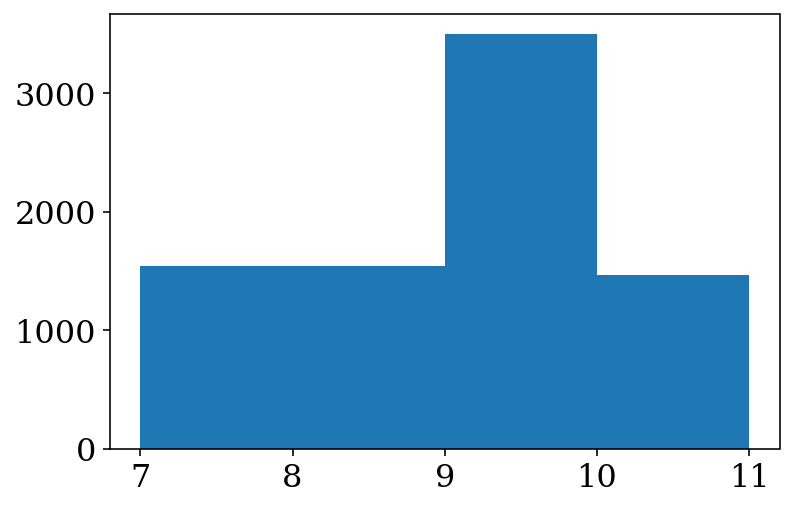

In [4]:
plt.hist(np.log10(mass), bins=[7, 9, 10, 11]);


### read in the output from `emcee` and trim

In [7]:
if os.path.exists("3betas.pkl"):
    
    infile = open("3betas.pkl",'rb')
    sampler = pickle.load(infile)
    infile.close()
else:
    print(""""You need to find the output of the emcee model in 
          cluster_cgm3_2_powerlaws_sum_with_2betas_2gammas.ipynb or rerun it""")

# get the > 1Mpc fit "2h_only"
if os.path.exists("2h_only_1Mpc_full_sampler.pkl"):
    
    infile = open("2h_only_1Mpc_full_sampler.pkl",'rb')
    sampler_2h_only = pickle.load(infile)
    infile.close()
else:
    print(""""You need to find the output of the emcee model in 
          cluster_cgm3_only_1Mpc_check_dNdz.ipynb or rerun it""")    
    
flat_samples = sampler.get_chain(discard=2000, thin=1, flat=True)
flat_samples_2h_only = sampler_2h_only.get_chain(discard=2000, thin=1, flat=True)

### compute the distributions of $R^{2,1}$, $R^{2,\rm total}$ at a fixed mass and radius

In [8]:
lo_edge, hi_edge = np.nanquantile(np.log10(mass), [0.3333, 0.6666])
print(lo_edge, hi_edge)
massidx = np.digitize(mass, [0, 10**lo_edge, 10**hi_edge, 10**13])
massidx -= 1

9.220335990817736 9.815912361965495


In [14]:
def compute_r21_rtotal(mass, redshift, thin=10, comoving=True, log=True, only_crossing=False):
    npts = 1000
    r_lin = np.geomspace(1e-10, 20, npts)
    m_lin = np.full(npts, 10**mass)
    midx_lin = np.digitize(m_lin, [0, 10**lo_edge, 10**hi_edge, 10**13]) - 1
    z_lin = np.full(npts, redshift)
    Hz_lin = cosmo.H(z_lin).value
    dv = 500.

    r21_sample = []
    r2total_sample = []
    count_2h_1h = 0
    count_2h_total = 0
    for sample, sample2h in zip(flat_samples[::thin], flat_samples_2h_only[::thin]):


        fc_1h = phit_1halo(sample, z_lin, r_lin, m_lin, midx_lin, Hz_lin, dv, vmax=500.)
        fc_2h = phit_2halo(sample, z_lin, r_lin, m_lin, midx_lin, Hz_lin, dv, vmax=500.)
        fc_total = phit_2_power_law_3betas(sample, z_lin, r_lin, m_lin, midx_lin, Hz_lin, dv, vmax=500.)
        fc_2h_only = phit_2halo_only(sample2h, z_lin, r_lin, m_lin, Hz_lin, dv, vmax=500.)


        # for two crossings...R21 or R2total = crossingpoint
        try:
            crossingpoint = np.where(np.diff(np.sign(fc_2h - fc_1h)) == 2)[0][0]
        except:
            # print(list(sample), list(sample2h))
            # this means the two halo term is always greater than the 1h term?
            if np.all(np.sign(fc_2h - fc_1h)) == 1:
                print("2h > 1h", mass)
                count_2h_1h += 1
            if np.all(np.sign(fc_2h - fc_1h)) == -1:
                print("1h > 2h")
                
            crossingpoint = 0
            
        try:
            crossingpoint_2h = np.where(np.diff(np.sign(fc_2h_only - fc_total)) == 2)[0][0]
        except IndexError:
            # print(list(sample), list(sample2h))
            if np.all(np.sign(fc_2h_only - fc_total)) == 1:
                print("2h_only > total")
                # print(list(sample), list(sample2h))
                count_2h_total += 1
            if np.all(np.sign(fc_2h_only - fc_total)) == -1:
                print("total > 2h_only")
                # pass
            # breakpoint()
            crossingpoint_2h = 0
        r21 = np.mean(r_lin[crossingpoint:crossingpoint+2])
        r2total = np.mean(r_lin[crossingpoint_2h:crossingpoint_2h+2])

        r21_sample.append(r21)
        r2total_sample.append(r2total)

    # convert to arrays in logspace
    r21_sample = np.array(r21_sample, dtype=np.float32)
    r2total_sample = np.array(r2total_sample, dtype=np.float32)
    
    # toss out zeros
    if only_crossing:
        r21_sample = np.where(r21_sample > 1e-5, r21_sample, np.nan)
        r2total_sample = np.where(r2total_sample > 1e-5, r2total_sample, np.nan)
    
    # convert to kpc
    r21_sample *= 1e3 
    r2total_sample *= 1e3
    
    if not comoving:
        r21_sample /= (1 + redshift) 
        r2total_sample /= (1 + redshift) 
    
    if log:
        r21_sample = np.log10(r21_sample)
        r2total_sample = np.log10(r2total_sample)
    

    
    return r21_sample, r2total_sample

In [15]:
r21_sample_m0, r2total_sample = compute_r21_rtotal(9.5, 0.1, thin=100, comoving=False, log=False, only_crossing=True)

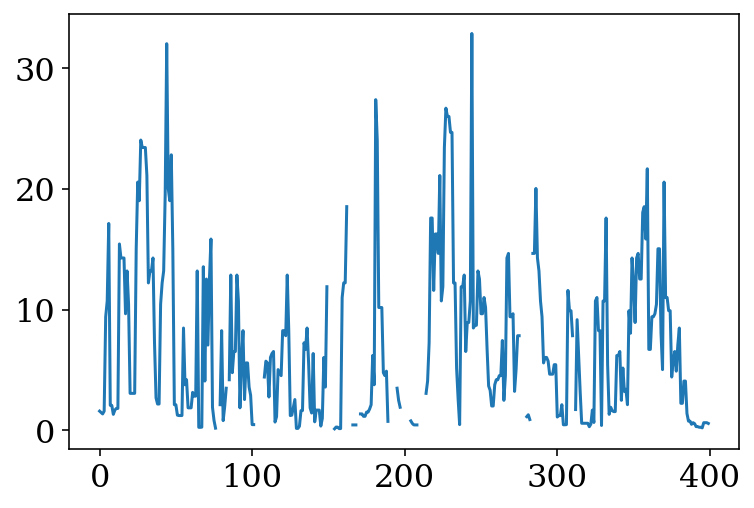

In [16]:
plt.plot(r21_sample_m0)

In [17]:
len(r21_sample_m0), len(r2total_sample)

(400, 400)

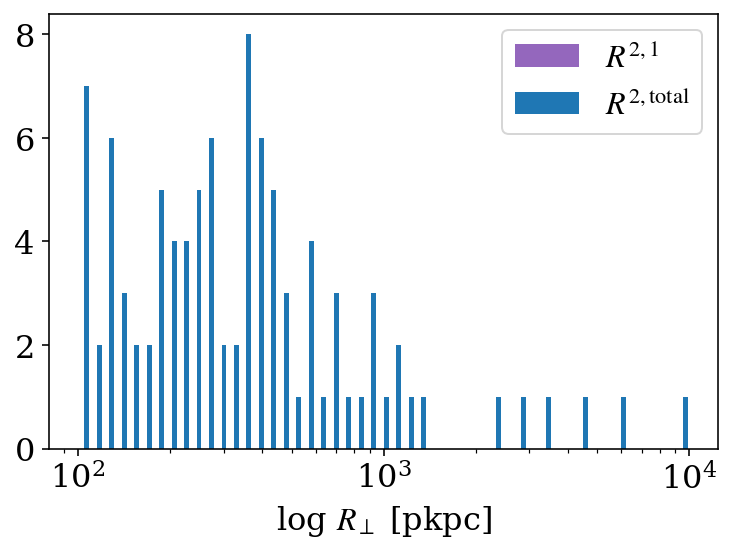

In [18]:
#plt.hist(np.log10(r2total_sample), bins=100);
#plt.hist(np.log10(r21_sample), bins=100);

plt.hist([r21_sample_m0, r2total_sample], 
         bins=np.geomspace(1e2, 1e4), 
         label=[r'$R^{2,1}$', r'$R^{2,\rm total}$'], 
         color=["tab:purple", "tab:blue"]);

plt.xscale('log')
plt.xlabel(r'log $R_{\perp}$ [pkpc]')
plt.legend();

In [19]:
r21_hi = np.nanquantile(r21_sample_m0, 0.86)
r21_med = np.nanquantile(r21_sample_m0, 0.5)
r21_low = np.nanquantile(r21_sample_m0, 0.14)

r2tot_hi = np.nanquantile(r2total_sample, 0.86)
r2tot_med = np.nanquantile(r2total_sample, 0.5)
r2tot_low = np.nanquantile(r2total_sample, 0.14)

print(r21_med, r2tot_med)

5.167194366455078 35.51142883300781


In [20]:
def limits(sample):
    
    hi = np.nanquantile(sample, 0.86)
    med = np.nanquantile(sample, 0.5)
    low = np.nanquantile(sample, 0.14)
    
    return med, hi, low
   

In [21]:
np.log10(mass.max())

11.32591037921554

### now make a grid of Rcgm in mass and redshift

In [22]:
npts_mass = 50
npts_z = 1

mass_space = np.linspace(7, 11.5, npts_mass)
#redshift_space = np.linspace(0.1, 0.5, npts_z)
redshift_space = [0.1]

r21_realization_list = []
r21_med_list = []
r21_hi_list = []
r21_low_list = []
r2tot_med_list = []
r2tot_hi_list = []
r2tot_low_list = []
for redshift in redshift_space:
    r21_realization_list_single_redshift = []
    r21_med_list_at_single_redshift = []
    r21_hi_list_at_single_redshift = []
    r21_low_list_at_single_redshift = []
    r2tot_med_list_at_single_redshift = []
    r2tot_hi_list_at_single_redshift = []
    r2tot_low_list_at_single_redshift = []
    for mass in mass_space:
        r21_sample, r2total_sample = compute_r21_rtotal(mass, redshift, thin=50, 
                                                        comoving=False, 
                                                        log=False, 
                                                        only_crossing=True)
        
        r21_med, r21_hi, r21_low = limits(r21_sample)
        r2tot_med, r2tot_hi, r2tot_low = limits(r2total_sample)
        
        r21_realization_list_single_redshift.append(r21_sample)
        r21_med_list_at_single_redshift.append(r21_med)
        r21_hi_list_at_single_redshift.append(r21_hi)
        r21_low_list_at_single_redshift.append(r21_low)
        r2tot_med_list_at_single_redshift.append(r2tot_med)
        r2tot_hi_list_at_single_redshift.append(r2tot_hi)
        r2tot_low_list_at_single_redshift.append(r2tot_low)

    r21_realization_list.append(r21_realization_list_single_redshift)    
    r21_med_list.append(r21_med_list_at_single_redshift)
    r21_hi_list.append(r21_hi_list_at_single_redshift)
    r21_low_list.append(r21_low_list_at_single_redshift)
    r2tot_med_list.append(r2tot_med_list_at_single_redshift)
    r2tot_hi_list.append(r2tot_hi_list_at_single_redshift)
    r2tot_low_list.append(r2tot_low_list_at_single_redshift)

2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1h 7.091836734693878
2h > 1

In [23]:
# get rvir
    
import casbah.gal_properties as caprop
logmhalo_z0p5 = [
        caprop.calchalomass(mstar, 0.5)
        for mstar in mass_space]

rvir_z0p5 = np.array([caprop.calcrvir(mh, 0.5) for mh in _z0p5])

In [24]:
r21_realization_arr = np.array(r21_realization_list)
r21_realization_arr.shape

(1, 50, 800)

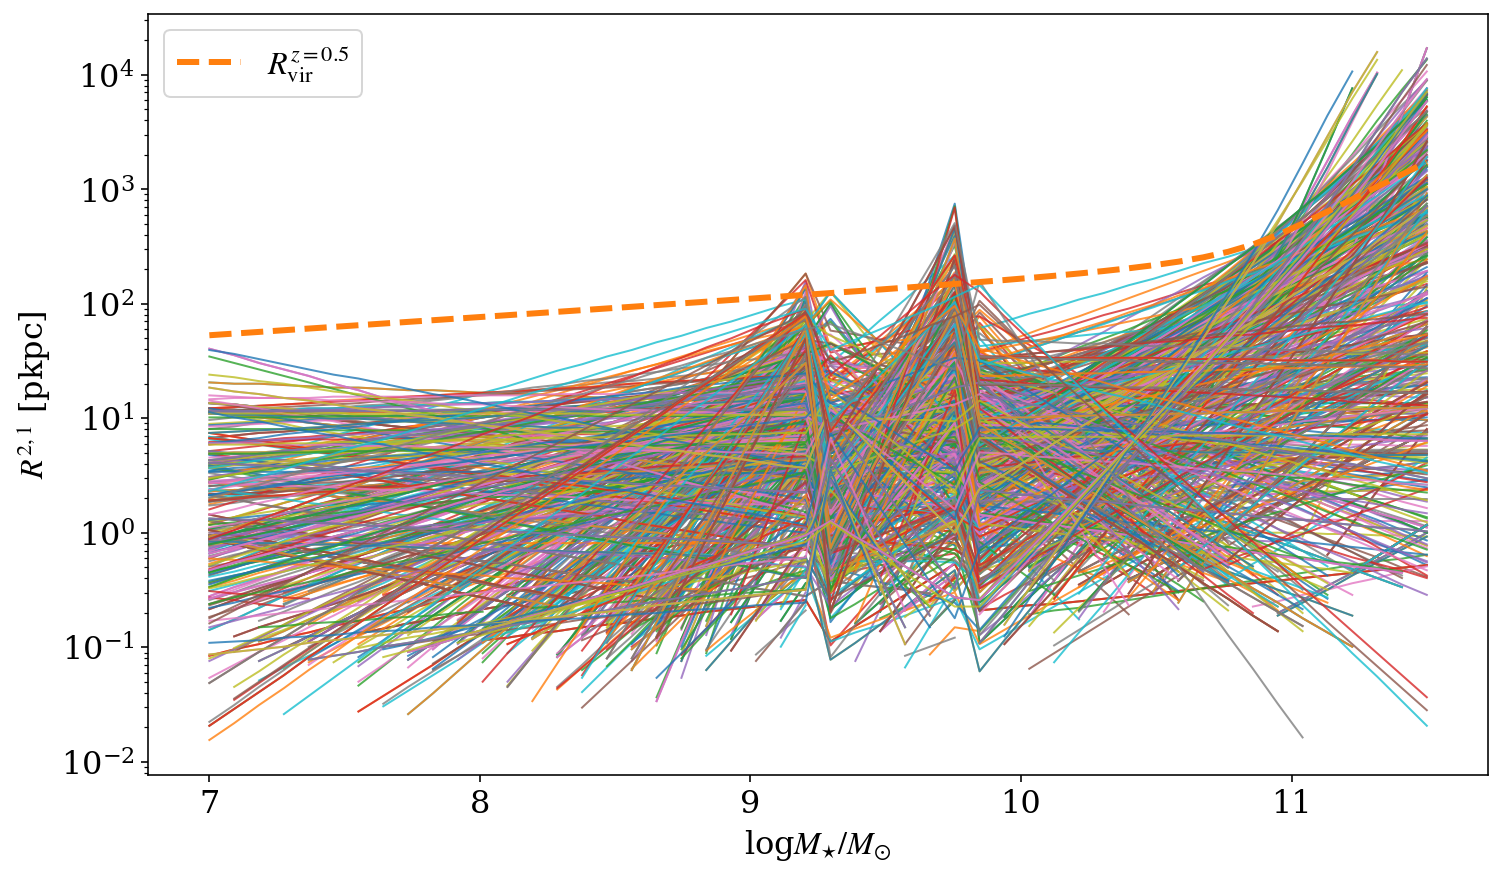

In [26]:
plt.figure(figsize=(12,7))

color=["tab:purple", "tab:blue"]

for idx, z in enumerate(redshift_space):
    # plt.plot(mass_space, r21_med_list[idx], label=f'z={z}', lw=3, color=color[idx])
    plt.plot(mass_space, r21_realization_arr[0,:,::1], lw=1, alpha=0.8)
    # plt.fill_between(mass_space, r21_low_list[idx], r21_hi_list[idx], color=color[idx],
    #                  alpha=0.1)

plt.plot(mass_space, rvir_z0p5, ls='--', lw=3, 
         label=r'$R_{\rm vir }^{z=0.5}$', c='tab:orange')
plt.yscale('log')
plt.xlabel(r'log$M_{\star}/M_{\odot}$');
plt.ylabel(r'$R^{2,1}$ [pkpc]')
# plt.axhline(np.nanmedian(r21_sample_m0))
# plt.legend(bbox_to_anchor=(1, 0.99));
plt.legend(loc='upper left');
plt.savefig("/Users/mwilde/Dropbox/Apps/Overleaf/cgmsquared_modelling/Figures/r21_mass_function.pdf")

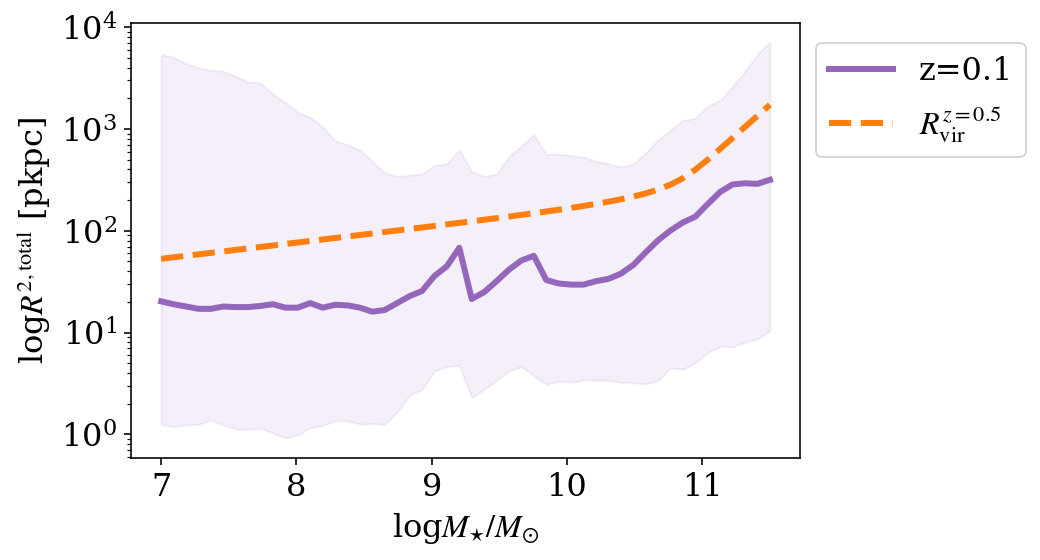

In [27]:
for idx, z in enumerate(redshift_space):
    plt.plot(mass_space, r2tot_med_list[idx], label=f'z={z}', lw=3, color=color[idx])
    plt.fill_between(mass_space, r2tot_low_list[idx], r2tot_hi_list[idx], color=color[idx],
                     alpha=0.1)
    
plt.plot(mass_space, rvir_z0p5, ls='--', lw=3, 
         label=r'$R_{\rm vir }^{z=0.5}$', c='tab:orange')

plt.yscale('log')
plt.xlabel(r'log$M_{\star}/M_{\odot}$');
plt.ylabel(r'log$R^{2,\rm total}$ [pkpc]')
plt.legend(bbox_to_anchor=(1, 0.99));

### small multiples

In [21]:
npts_mass = 7
npts_z = 3

mass_space = np.linspace(7, 13, npts_mass)
redshift_space = np.linspace(0.1, 0.5, npts_z)


def mass_redshift_grid(mass_space, redshift_space, log=True, comoving=False, only_crossing=False):

    #mass_space = np.linspace(7, 13, npts_mass)
    #redshift_space = np.linspace(0.01, 0.5, npts_z)

    r21_med_list = []
    r21_hi_list = []
    r21_low_list = []
    r2tot_med_list = []
    r2tot_hi_list = []
    r2tot_low_list = []

    r2tot_sample_list = []
    r21_sample_list = []
    for redshift in redshift_space:
        r21_med_list_at_single_redshift = []
        r21_hi_list_at_single_redshift = []
        r21_low_list_at_single_redshift = []
        r2tot_med_list_at_single_redshift = []
        r2tot_hi_list_at_single_redshift = []
        r2tot_low_list_at_single_redshift = []

        r2tot_sample_at_single_redshift = []
        r21_sample_at_single_redshift = []
        for mass in mass_space:
            r21_sample, r2total_sample = compute_r21_rtotal(mass, redshift, 
                                                            thin=500, 
                                                            comoving=comoving, 
                                                            log=log, 
                                                            only_crossing=only_crossing)

            r21_med, r21_hi, r21_low = limits(r21_sample)
            r2tot_med, r2tot_hi, r2tot_low = limits(r2total_sample)

            r21_med_list_at_single_redshift.append(r21_med)
            r21_hi_list_at_single_redshift.append(r21_hi)
            r21_low_list_at_single_redshift.append(r21_low)
            r2tot_med_list_at_single_redshift.append(r2tot_med)
            r2tot_hi_list_at_single_redshift.append(r2tot_hi)
            r2tot_low_list_at_single_redshift.append(r2tot_low)

            r2tot_sample_at_single_redshift.append(r2total_sample)
            r21_sample_at_single_redshift.append(r21_sample)

        r21_med_list.append(r21_med_list_at_single_redshift)
        r21_hi_list.append(r21_hi_list_at_single_redshift)
        r21_low_list.append(r21_low_list_at_single_redshift)
        r2tot_med_list.append(r2tot_med_list_at_single_redshift)
        r2tot_hi_list.append(r2tot_hi_list_at_single_redshift)
        r2tot_low_list.append(r2tot_low_list_at_single_redshift)

        r2tot_sample_list.append(r2tot_sample_at_single_redshift)
        r21_sample_list.append(r21_sample_at_single_redshift)
    return r21_sample_list, r2tot_sample_list


In [22]:
r21_sample_list, r2tot_sample_list = mass_redshift_grid(mass_space, redshift_space, comoving=False)

2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0
2h > 1h 7.0


IndexError: index 3 is out of bounds for axis 0 with size 3

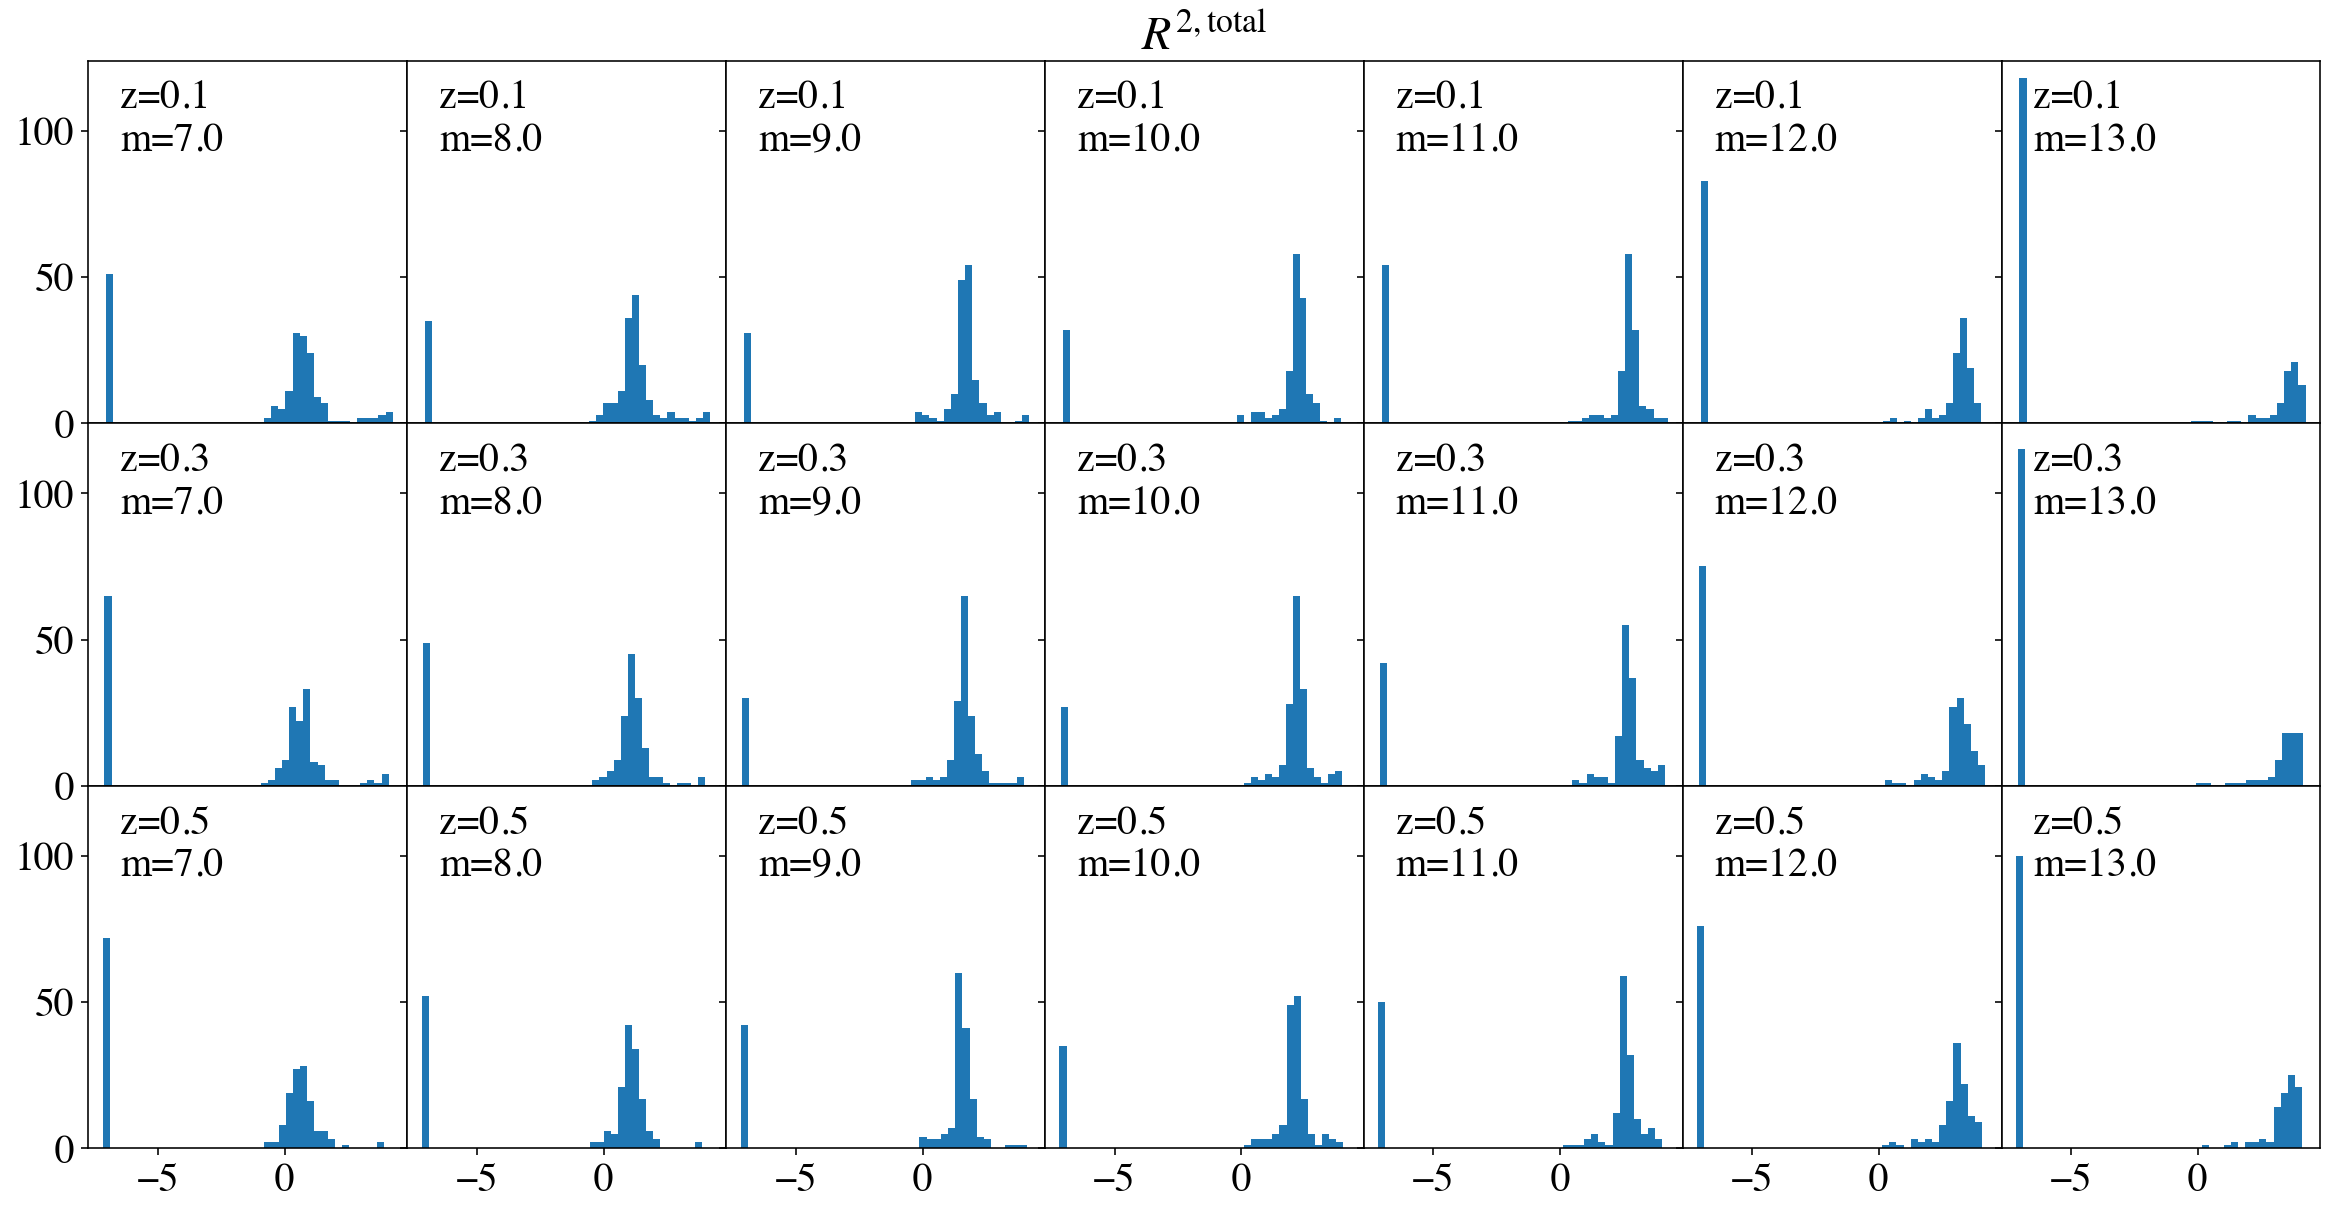

In [ ]:
fig, axes = plt.subplots(ncols=len(mass_space), nrows=len(redshift_space), 
                         figsize=(20,10), sharex=True, sharey=True)

for idx_z, z in enumerate(redshift_space):
    for idx_m, mass in enumerate(mass_space):
        label="z={0} \nm={1}".format(np.round(z,1), np.round(mass, 1))
        axes[idx_z][idx_m].hist(r2tot_sample_list[idx_z][idx_m], bins=40, label="z={0} \nm={1}".format(z, mass))
        # axes[idx_z, idx_m].legend()
        axes[idx_z, idx_m].text(0.1, 0.75, s=label, transform=axes[idx_z, idx_m].transAxes)

plt.subplots_adjust(wspace=0, hspace=0)

axes[0,3].set_title(r"$R^{2, \rm total}$");

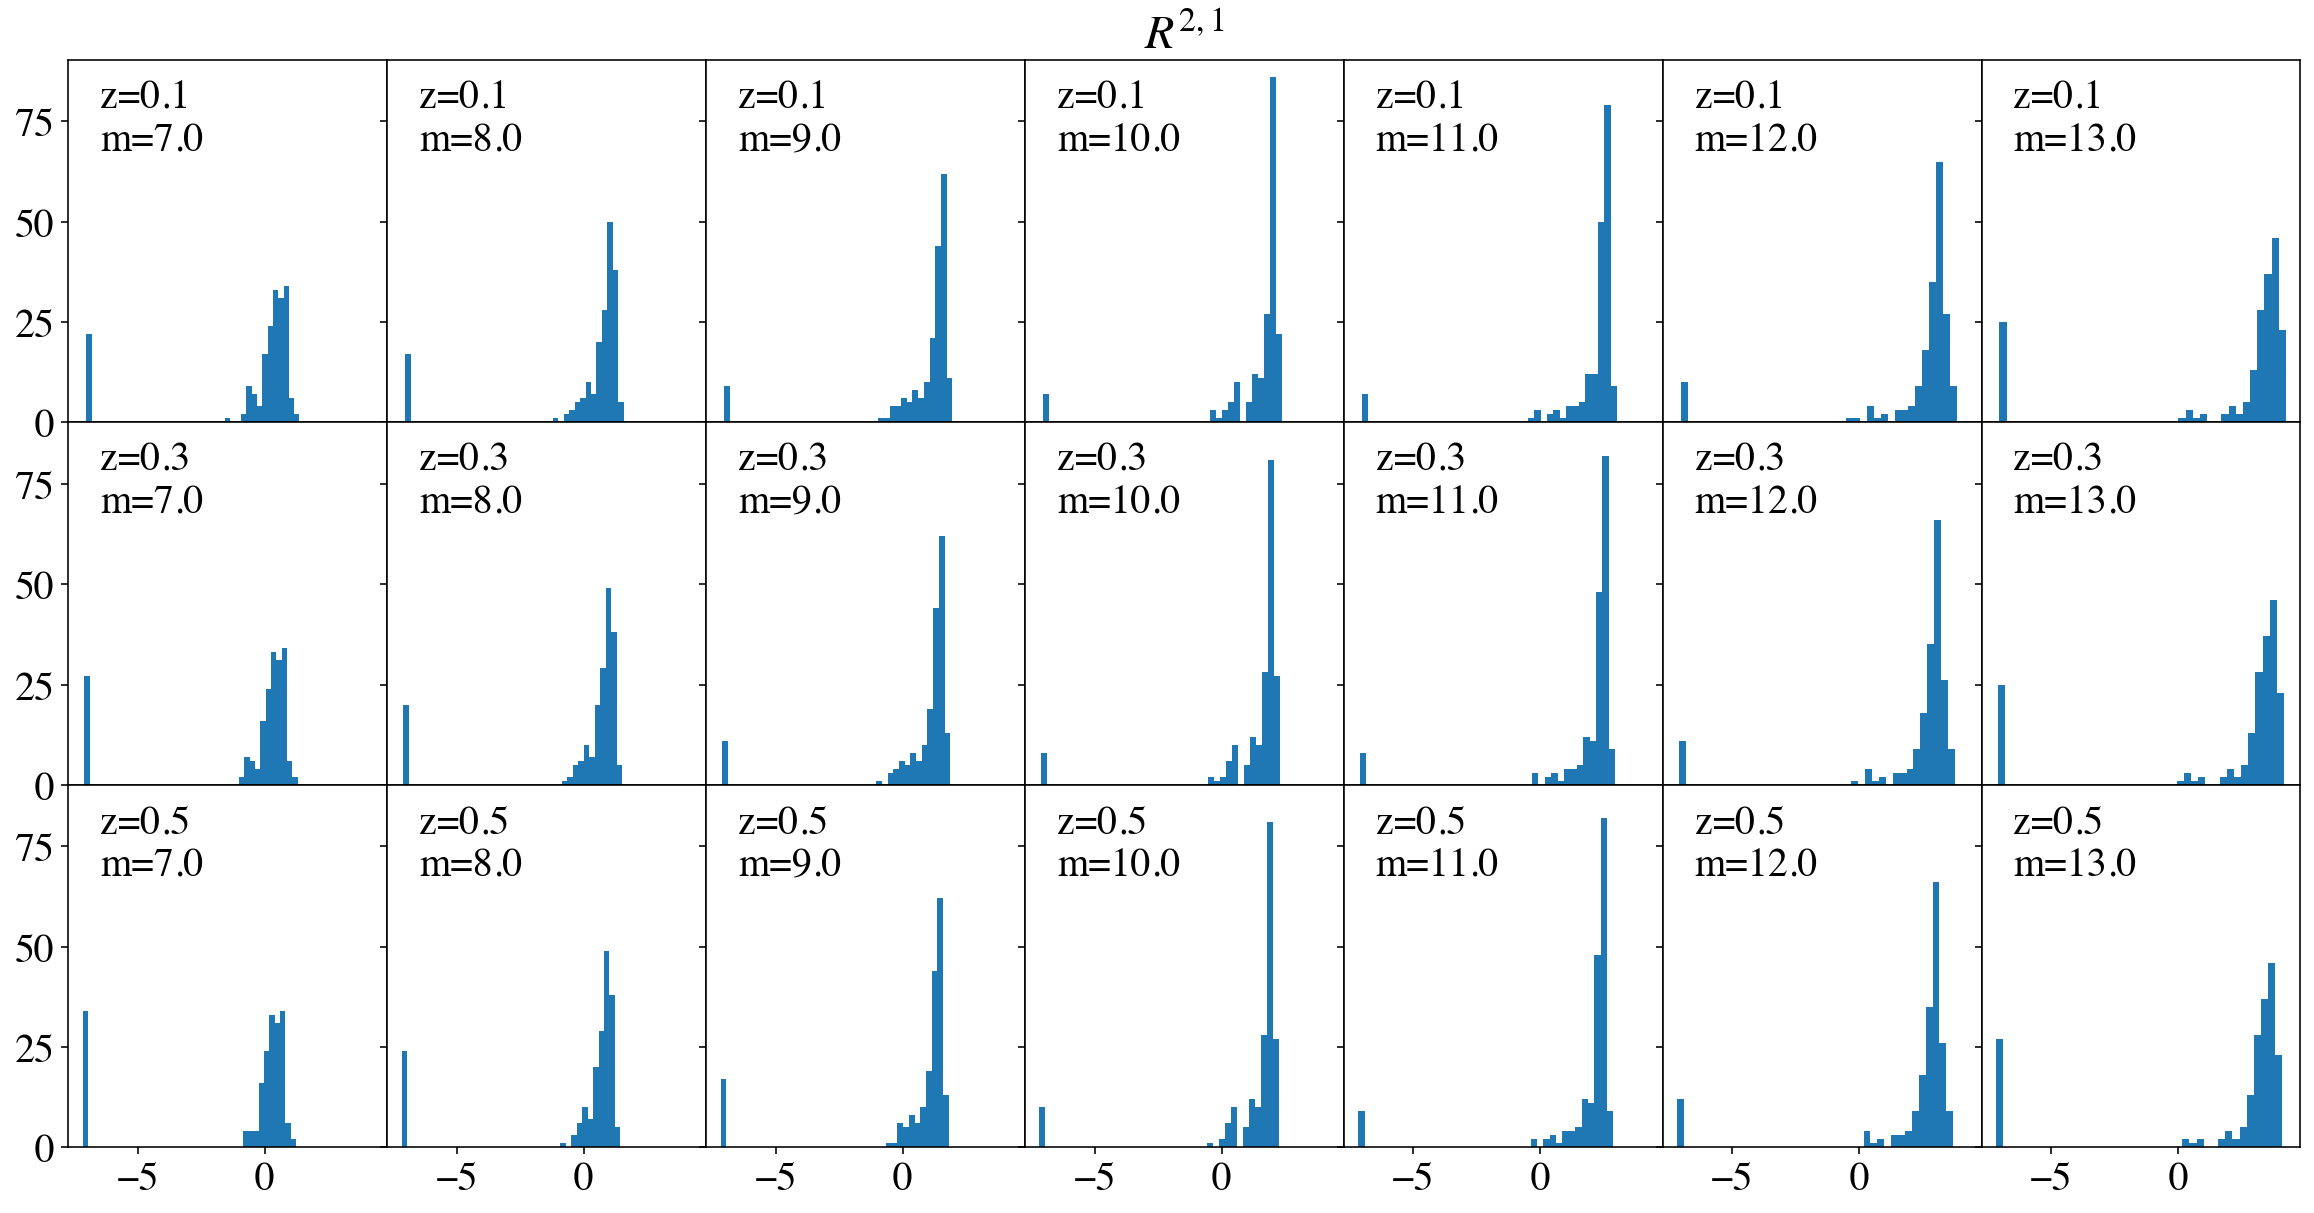

In [ ]:
fig, axes = plt.subplots(ncols=len(mass_space), nrows=len(redshift_space), 
                         figsize=(20,10), sharex=True, sharey=True)

for idx_z, z in enumerate(redshift_space):
    for idx_m, mass in enumerate(mass_space):
        label="z={0} \nm={1}".format(np.round(z,1), np.round(mass, 1))
        axes[idx_z][idx_m].hist(r21_sample_list[idx_z][idx_m], bins=40, label="z={0} \nm={1}".format(z, mass))
        axes[idx_z, idx_m].text(0.1, 0.75, s=label, transform=axes[idx_z, idx_m].transAxes)
        # axes[idx_z, idx_m].legend()

plt.subplots_adjust(wspace=0, hspace=0)

axes[0,3].set_title(r"$R^{2,1}$");

# many times the two profiles do not cross. So, if we assume that we are only includiing models that do cross, we can toss those and see what we get. 

In [ ]:
def small_multiples_plot(sample_list, mass_space, redshift_space):

    fig, axes = plt.subplots(ncols=len(mass_space), nrows=len(redshift_space), 
                             figsize=(20,10), sharex=True, sharey=True)

    for idx_z, z in enumerate(redshift_space):
        for idx_m, mass in enumerate(mass_space):
            label="z={0} \nm={1}".format(np.round(z,1), np.round(mass, 1))
            axes[idx_z, idx_m].hist(sample_list[idx_z][idx_m], bins=40, label=label)
            # axes[idx_z, idx_m].legend()
            axes[idx_z, idx_m].text(0.1, 0.75, s=label, transform=axes[idx_z, idx_m].transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    return axes


In [ ]:
r21_sample_list_no_zero, r2tot_sample_list_no_zero = mass_redshift_grid(mass_space, redshift_space, comoving=False, log=True, only_crossing=True)

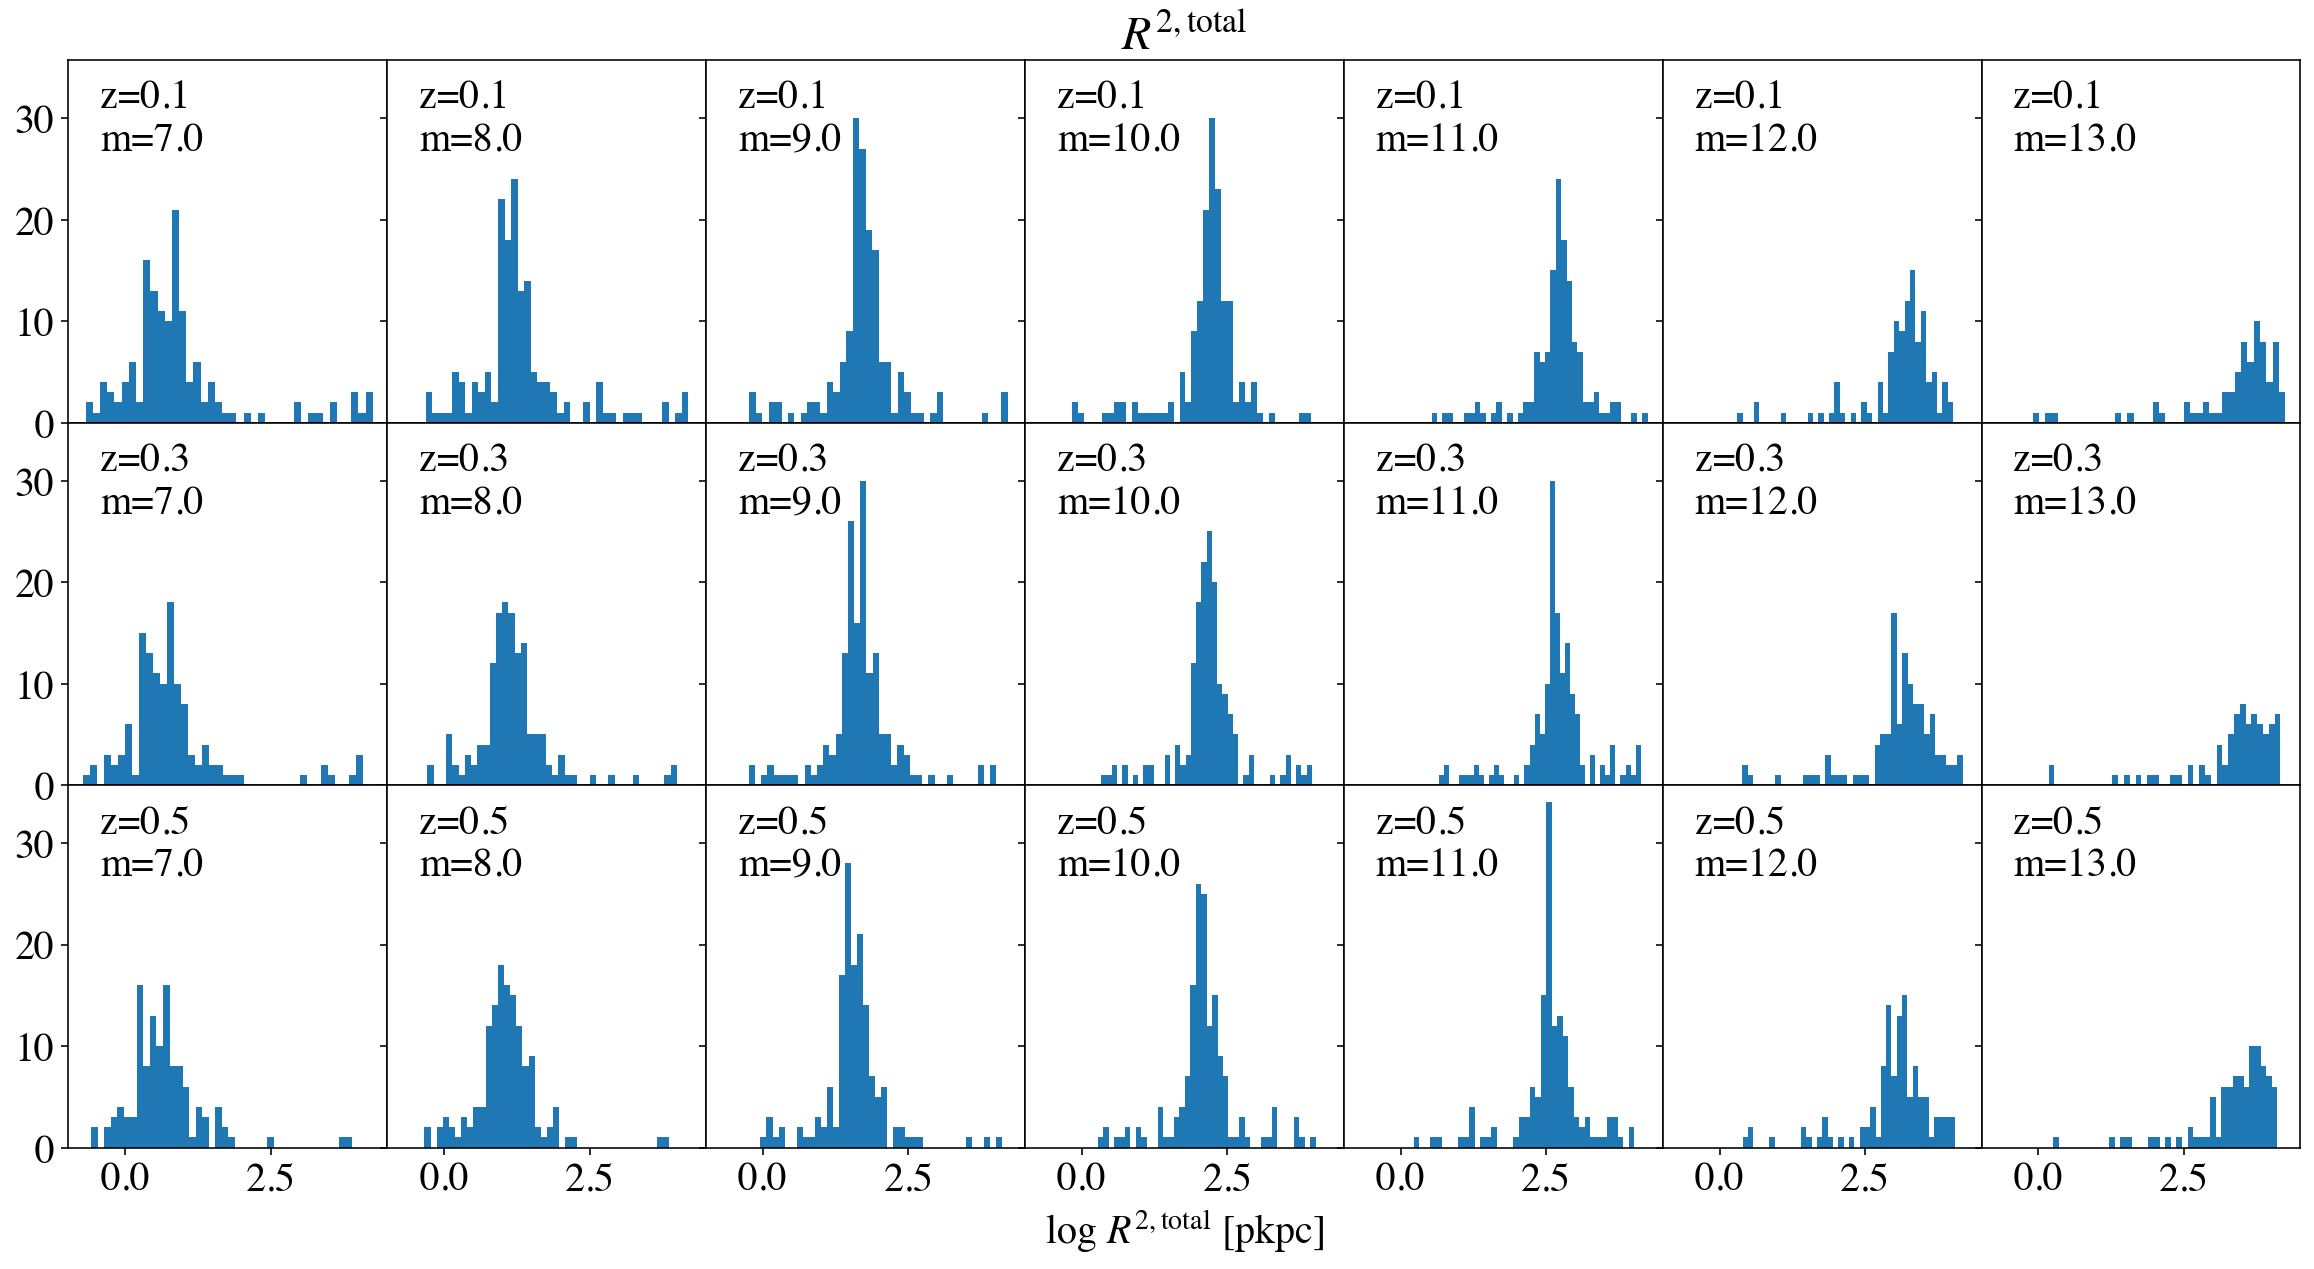

In [ ]:
axes = small_multiples_plot(r2tot_sample_list_no_zero, mass_space, redshift_space)
axes[0,3].set_title(r"$R^{2, \rm total}$");
axes[2,3].set_xlabel(r"log $R^{2,\rm total}$ [pkpc]");
# plt.show()

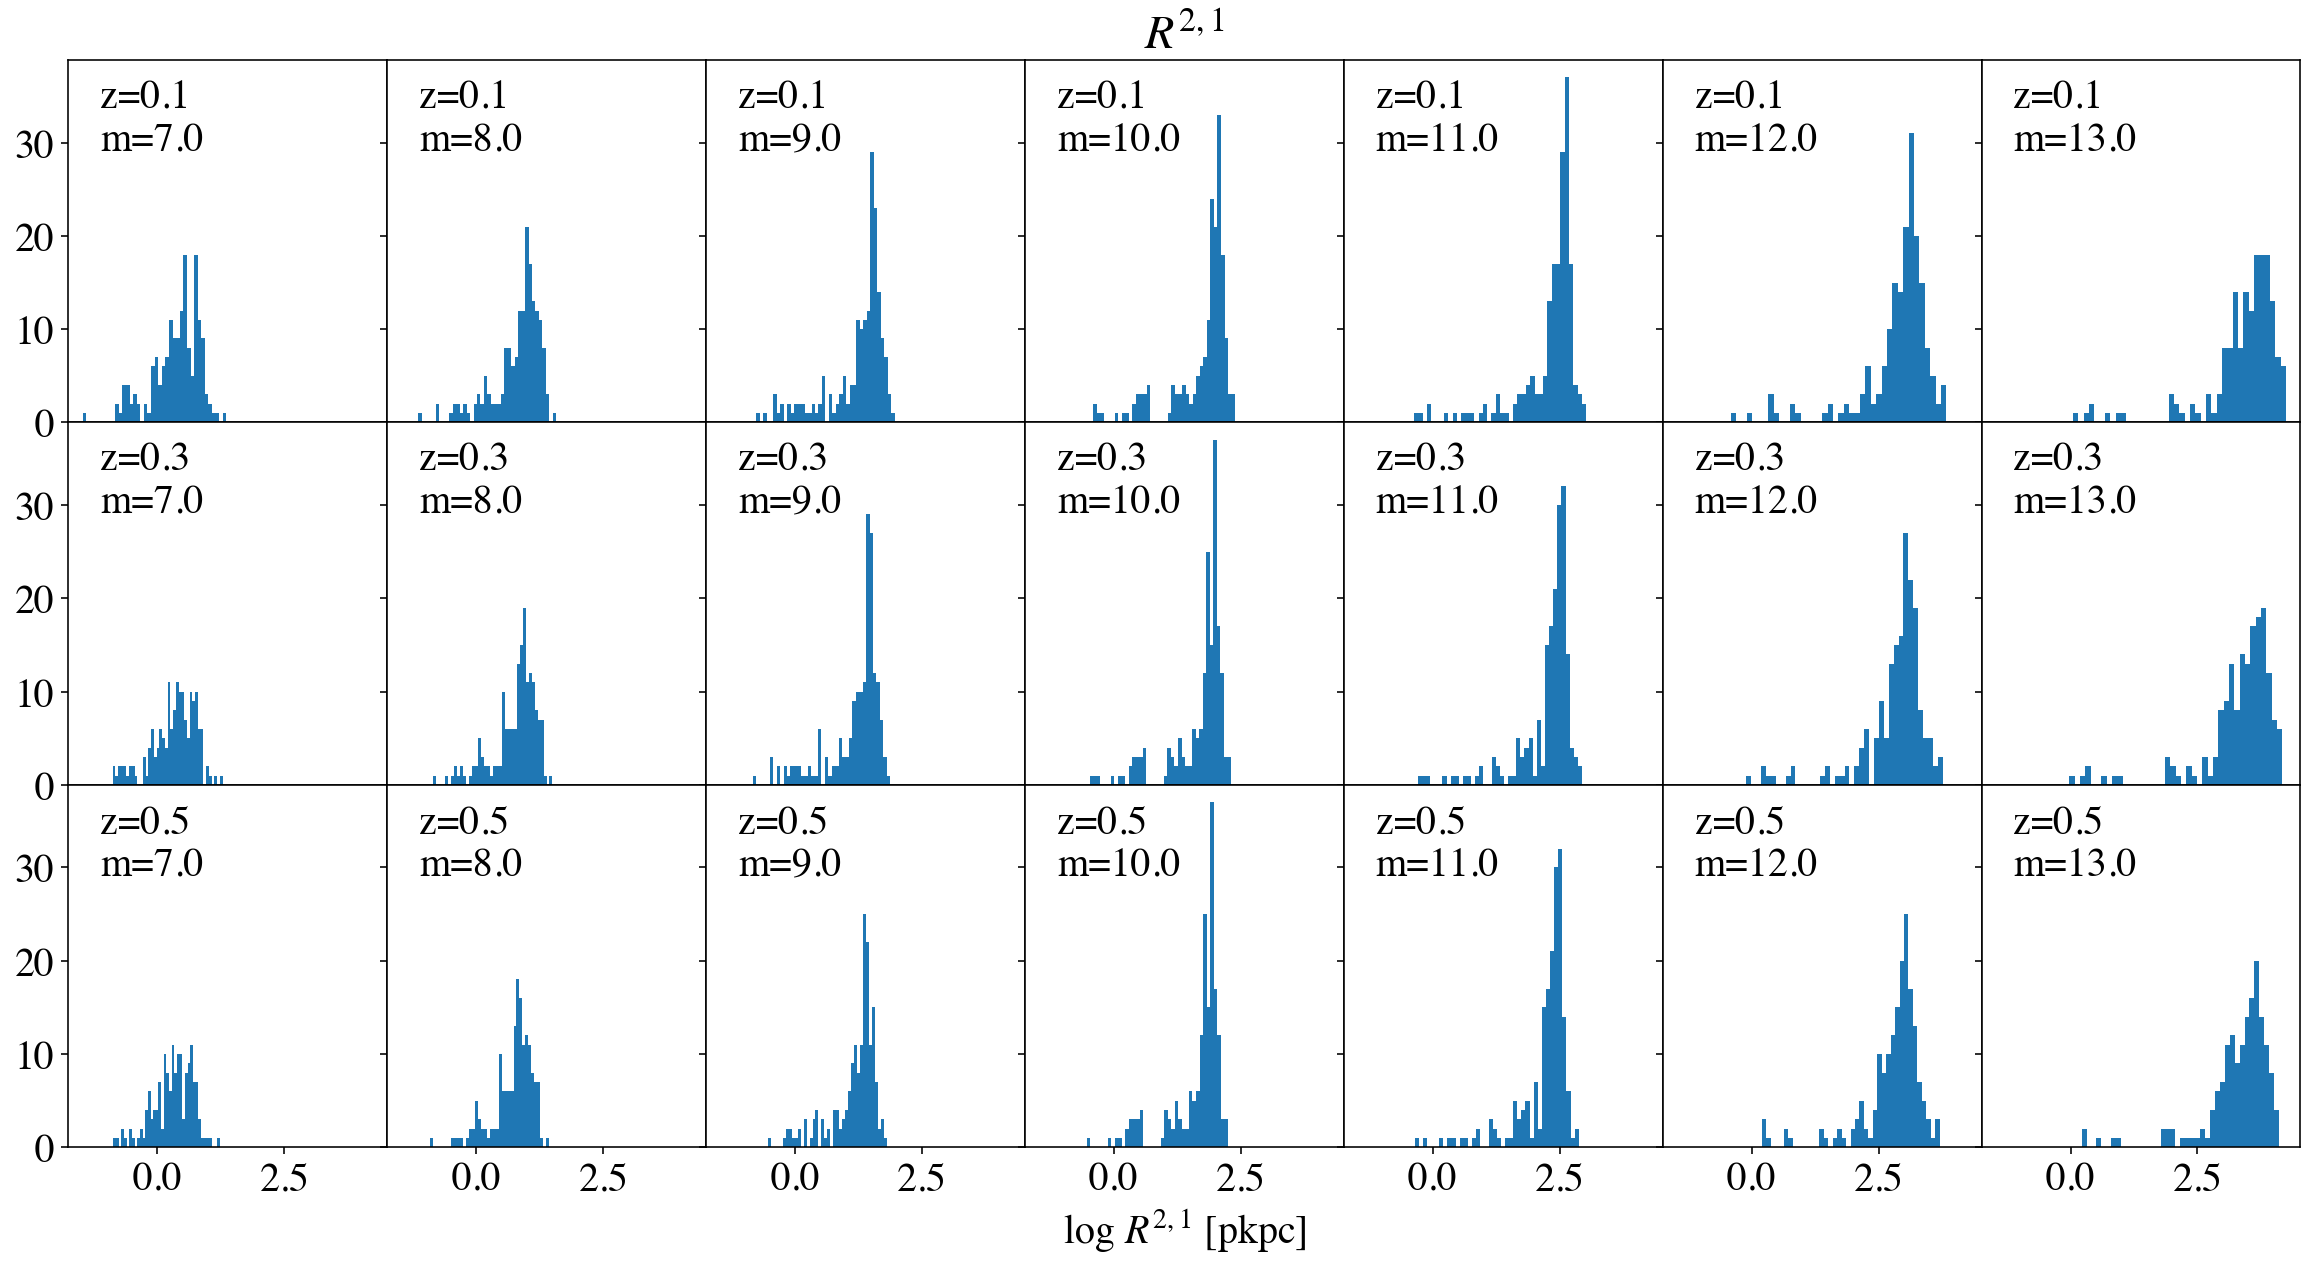

In [ ]:
axes = small_multiples_plot(r21_sample_list_no_zero, mass_space, redshift_space)
axes[0,3].set_title(r"$R^{2,1}$");
axes[2,3].set_xlabel(r"log $R^{2,1}$ [pkpc]");